# Практическая работа №2
## Королев Павел Александрович

# Цель:
изучение архитектур сверточных нейронных сетей, технологии переноса обучения; создание и исследование моделей сверточных нейронных сетей для задачи классификации. 
# Исходные данные:
Наборы данных содержат изображения различных бетонных поверхностей с трещинами и без них. Данные изображения разделены на две части: негативные (без трещин) и позитивные (с трещинами) в отдельной папке для классификации изображений. Каждый класс имеет 20 000 изображений, всего 40 000 изображений размером 227 x 227 пикселей с каналами RGB. Набор данных создается из 458 изображений с высоким разрешением (4032x3024 пикселей) с помощью метода, предложенного Zhang et al (2016). Выяснилось, что изображения с высоким разрешением сильно различаются по качеству обработки поверхности и условиям освещения. Никакого увеличения данных с точки зрения случайного вращения, переворота или наклона не применяется.

In [33]:
import os
import cv2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Предобработка данных

In [17]:
class PositiveNegativeCracks():
    IMG_SIZE = 50
    negatives = "Negative"
    positives = "Positive"
    labels = {negatives: 0, positives: 1}

    training_data = []
    positive_count = 0
    negative_count = 0

    def make_training_data(self):
        for label in self.labels:
            for file in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]])

                    if label == self.negatives:
                        self.negative_count += 1
                    elif label == self.positives:
                        self.positive_count += 1
                except Exception as e:
                    print(str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Positives:", self.positive_count)
        print("Negatives:", self.negative_count)

In [18]:
dataSet = PositiveNegativeCracks()
dataSet.make_training_data()

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:26<00:00, 230.16it/s]
C:\Coding\Anaconda\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Positives: 20000
Negatives: 20000


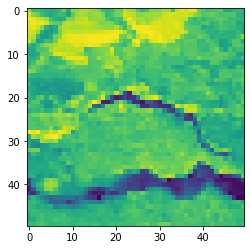

In [28]:
training_data = np.load("training_data.npy", allow_pickle=True)
plt.imshow(training_data[50][0])
plt.show()

In [78]:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0
y = torch.Tensor([i[1] for i in training_data])

In [79]:
test_size = 8000
val_size = 8000

train_X = X[:-val_size]
train_y = y[:-val_size]

valid_X = train_X[-test_size:]
valid_y = train_y[-test_size:]
train_X = train_X[:-test_size]
train_y = train_y[:-test_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

# Функции упрощения жизни

In [212]:
# График
def create_acc_loss_graph(train_losses, valid_losses):
    fig = plt.figure(figsize=(20, 10))
    ax1 = plt.subplot2grid((2,1), (0,0))

    ax1.plot(train_losses, label="train_loss")
    ax1.plot(valid_losses, label="val_loss")
    ax1.legend(loc=2)

    plt.show()

In [208]:
def trainer_func(name, classifier, Loss_func, optimizer, epochs, train_X, train_y, valid_X, valid_y):
    trained_path = 'trained_classifier_' + name + '.pt'
    best_valid_loss = 100
    valid_loss_min = np.Inf 
    classifier.train()
    batch_size = 100
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        running_loss = 0
        valid_loss = 0
        pbar = tqdm(range(0, len(train_X), batch_size), position=0, leave=True)
        for i in pbar:
            pbar.set_description('Epoch' + str(epoch+1))
            batch_x = train_X[i:i+batch_size].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+batch_size]
            
            classifier.zero_grad()
            outputs = classifier(batch_x)
            loss = Loss_func(outputs, batch_y)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
            valid_batch = random.randint(0, len(valid_X) - batch_size)
            batch_x = valid_X[valid_batch:valid_batch+batch_size].view(-1, 1, 50, 50)
            batch_y = valid_y[valid_batch:valid_batch+batch_size]
            
            outputs = classifier(batch_x)
            loss = Loss_func(outputs, batch_y)
            valid_losses.append(loss.item())
            if best_valid_loss > valid_losses[-1]:
                best_valid_loss = valid_losses[-1]
                torch.save(classifier.state_dict(), trained_path)
        tqdm.write(f'Train loss: {train_losses[-1]}\nValid loss: {valid_losses[-1]}\nBest valid loss: {best_valid_loss}')
    return trained_path, train_losses, valid_losses

In [229]:
def accuracy_loss(answers, y):
    answer_pos = []
    answer_neg = []
    for i in range(len(answers)):
        if y[i][1] == 1:
            answer_pos.append(int(answers[i] == y[i][1]))
        else:
            answer_neg.append(int(answers[i] == y[i][1]))
    all_loss = (sum(answer_neg) + sum(answer_pos))/len(answer_neg + answer_pos)
    pos_loss = sum(answer_pos)/len(answer_pos)
    neg_loss = sum(answer_neg)/len(answer_neg)
    return all_loss, pos_loss, neg_loss 

def tester_func(classifier, Loss_func, test_X, test_y):
    test_loss = 0
    answers = []
    outputs = []
    batch_size = 100

    classifier.eval()
    pbar = tqdm(range(0, len(test_X), batch_size), position=0, leave=True)
    for i in pbar:
        pbar.set_description('Test')
        batch_x = test_X[i:i+batch_size].view(-1, 1, 50, 50)
        batch_y = test_y[i:i+batch_size]

        output = classifier(batch_x)
        outputs += output.tolist()
        _, pred = torch.max(output, 1)
        answers += pred.tolist()
    outputs = torch.tensor(outputs)
    loss = Loss_func(outputs, test_y)
    acc_loss = accuracy_loss(answers, test_y)
    
    print('Loss:', loss.item())
    print('All accuracy: ', acc_loss[0])
    print('Positive accuracy: ', acc_loss[1])
    print('Negative accuracy: ', acc_loss[2])

# Нейронки

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

### Попытка 1

In [222]:
class Net_1(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.model_name = model_name

        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.conv4 = nn.Conv2d(128, 256, (3, 3))

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None

        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)   

In [223]:
name = 'fitst_net'
classifier = Net_1(name)
Loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
epochs = 2
train_X = train_X
train_y = train_y
valid_X = valid_X
valid_y = valid_y

trained_path, train_losses, valid_losses = trainer_func(name, classifier, Loss_func, optimizer, epochs, train_X, train_y, valid_X, valid_y)

Epoch2:   0%|▎                                                                         | 1/240 [00:00<00:45,  5.31it/s]

Train loss: 0.35794609785079956
Valid loss: 0.373460054397583
Best valid loss: 0.3132660984992981


Epoch2: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:46<00:00,  5.17it/s]

Train loss: 0.33315250277519226
Valid loss: 0.35328760743141174
Best valid loss: 0.3132660984992981


In [224]:
classifier.load_state_dict(torch.load(trained_path))

<All keys matched successfully>

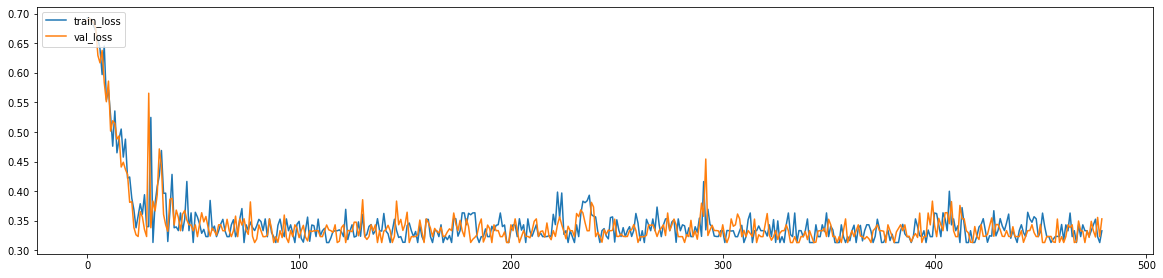

In [225]:
create_acc_loss_graph(train_losses, valid_losses)

In [230]:
tester_func(classifier, Loss_func, test_X, test_y)

Test: 100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 17.37it/s]


Loss: 0.335635781288147
All accuracy:  0.977375
Positive accuracy:  0.991
Negative accuracy:  0.96375


### Попытка 2

In [240]:
class Net_2(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.model_name = model_name

        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.conv4 = nn.Conv2d(128, 256, (3, 3))

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None

        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.avg_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.avg_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.avg_pool2d(F.relu(self.conv4(x)), (2, 2))

        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

In [234]:
name = 'second_net'
classifier = Net_2(name)
Loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
epochs = 2
train_X = train_X
train_y = train_y
valid_X = valid_X
valid_y = valid_y

trained_path, train_losses, valid_losses = trainer_func(name, classifier, Loss_func, optimizer, epochs, train_X, train_y, valid_X, valid_y)

Epoch2:   0%|▎                                                                         | 1/240 [00:00<00:41,  5.73it/s]

Train loss: 0.34446725249290466
Valid loss: 0.3462948501110077
Best valid loss: 0.313902884721756


Epoch2: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:44<00:00,  5.39it/s]

Train loss: 0.3398676812648773
Valid loss: 0.35270610451698303
Best valid loss: 0.31328245997428894


In [235]:
classifier.load_state_dict(torch.load(trained_path))

<All keys matched successfully>

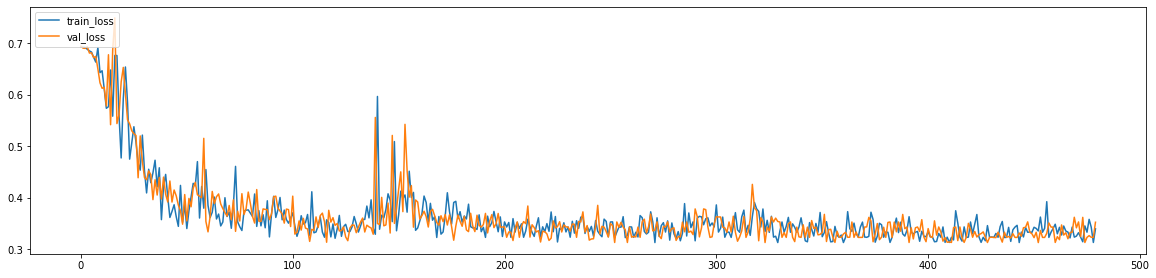

In [237]:
create_acc_loss_graph(train_losses, valid_losses)

In [236]:
tester_func(classifier, Loss_func, test_X, test_y)

Test: 100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 18.23it/s]


Loss: 0.33943021297454834
All accuracy:  0.97325
Positive accuracy:  0.95
Negative accuracy:  0.9965


### Попытка 3

In [283]:
class Net_3(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.model_name = model_name

        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.conv4 = nn.Conv2d(128, 256, (3, 3))

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None

        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.softplus(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)   

In [284]:
name = 'third_net'
classifier = Net_3(name)
Loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
epochs = 2
train_X = train_X
train_y = train_y
valid_X = valid_X
valid_y = valid_y

trained_path, train_losses, valid_losses = trainer_func(name, classifier, Loss_func, optimizer, epochs, train_X, train_y, valid_X, valid_y)

Epoch2:   0%|▎                                                                         | 1/240 [00:00<00:40,  5.88it/s]

Train loss: 0.02108607441186905
Valid loss: 0.05686505138874054
Best valid loss: 0.004126017913222313


Epoch2: 100%|████████████████████████████████████████████████████████████████████████| 240/240 [00:43<00:00,  5.52it/s]

Train loss: 0.01853332109749317
Valid loss: 0.06365368515253067
Best valid loss: 0.0013502156361937523


In [285]:
classifier.load_state_dict(torch.load(trained_path))

<All keys matched successfully>

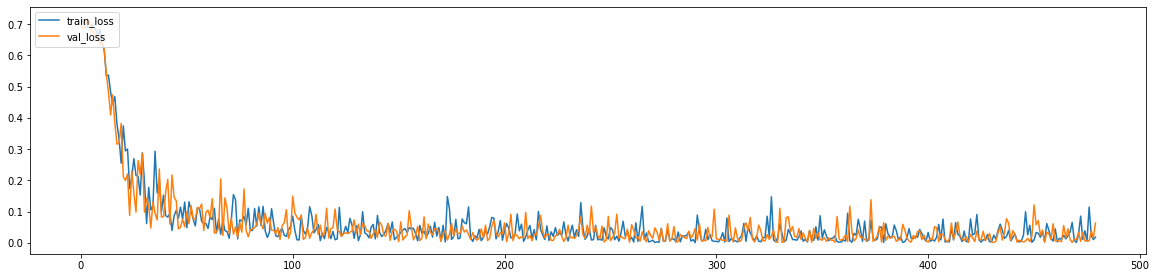

In [286]:
create_acc_loss_graph(train_losses, valid_losses)

In [287]:
tester_func(classifier, Loss_func, test_X, test_y)

Test: 100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 17.73it/s]


Loss: 0.033019423484802246
All accuracy:  0.987875
Positive accuracy:  0.979
Negative accuracy:  0.99675


## Попытка 4

In [288]:
class Net_4(nn.Module):
    def __init__(self, model_name):
        super().__init__()

        self.model_name = model_name

        self.conv1 = nn.ConvTranspose2d(1, 32, (3, 3))
        self.conv2 = nn.ConvTranspose2d(32, 64, (3, 3))
        self.conv3 = nn.ConvTranspose2d(64, 128, (3, 3))

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None

        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.adaptive_avg_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.adaptive_avg_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.adaptive_avg_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.softplus(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

Conv2d захватывает предыдущее окно, ConvTranspose2d нет

In [289]:
name = 'finally'
classifier = Net_4(name)
Loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
epochs = 10
train_X = train_X
train_y = train_y
valid_X = valid_X
valid_y = valid_y

trained_path, train_losses, valid_losses = trainer_func(name, classifier, Loss_func, optimizer, epochs, train_X, train_y, valid_X, valid_y)

Epoch2:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.48740413784980774
Valid loss: 0.5226678252220154
Best valid loss: 0.4367222487926483


Epoch3:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.4051908254623413
Valid loss: 0.3888116180896759
Best valid loss: 0.3376834988594055


Epoch4:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.36538687348365784
Valid loss: 0.34574395418167114
Best valid loss: 0.32479530572891235


Epoch5:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.34911832213401794
Valid loss: 0.3532088100910187
Best valid loss: 0.3138936460018158


Epoch6:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.35199058055877686
Valid loss: 0.33402976393699646
Best valid loss: 0.313871830701828


Epoch7:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.3367367684841156
Valid loss: 0.35409289598464966
Best valid loss: 0.31348851323127747


Epoch8:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.8132615685462952
Valid loss: 0.8732616305351257
Best valid loss: 0.31334513425827026


Epoch9:   0%|                                                                                  | 0/240 [00:00<?, ?it/s]

Train loss: 0.8132615685462952
Valid loss: 0.9232616424560547
Best valid loss: 0.31334513425827026


Epoch10:   0%|                                                                                 | 0/240 [00:00<?, ?it/s]

Train loss: 0.8132615685462952
Valid loss: 0.8632616400718689
Best valid loss: 0.31334513425827026


Epoch10: 100%|███████████████████████████████████████████████████████████████████████| 240/240 [01:18<00:00,  3.04it/s]

Train loss: 0.8132615685462952
Valid loss: 0.8232617378234863
Best valid loss: 0.31334513425827026


In [290]:
classifier.load_state_dict(torch.load(trained_path))

<All keys matched successfully>

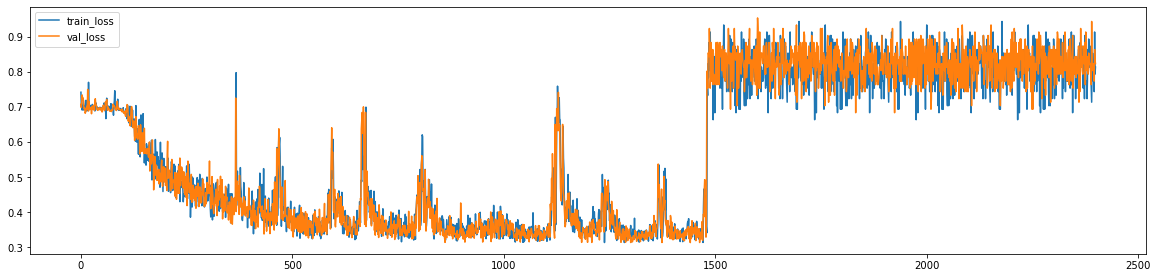

In [291]:
create_acc_loss_graph(train_losses, valid_losses)

In [292]:
tester_func(classifier, Loss_func, test_X, test_y)

Test: 100%|████████████████████████████████████████████████████████████████████████████| 80/80 [00:09<00:00,  8.87it/s]


Loss: 0.3371204137802124
All accuracy:  0.974625
Positive accuracy:  0.96525
Negative accuracy:  0.984
